# Meteorološki podatki 

Najprej potrebujemo pridobiti meteorološke podatke na lokaciji stavbe.
Le ta stoji v Ljubljani, zato so GK koordinate sledeče: Y = 462645 m, X = 102486 m, pridobljeni podatki pa sledeči:

 - projektna temperatura okolice  $\theta_{e, ref}$: **-13°C**
 - povprečna letna temperatura okolice $\theta_{e, ann}$: **9.9°C**
 - povprečna mesečna dnevna energija sončnega obsevanja $G_{sol,i,d}$: **1121 kWh/m$^{2}$**
 - povprečna dnevna temperatura okolice $\theta_{e, d}$: Izračunana v naslednjih korakih.

In [1]:
thetaeref = -13 #°C
thetaeann = 9.9 #°C
gsolid = 1121 #kWh/m2

Uvozimo potrebne module

In [2]:
import matplotlib.pyplot as plt
import numpy as np
#Ne želimo znanstvenega zapisa števil
np.set_printoptions(suppress=True)

Uvozimo podatke za tipično leto.
Podatki so v CSV datoteki, katero je treba obdelati. Le to storimo s programom, ki je v modulu zModel. 

In [3]:
import zModel

Funkcija `temperaturesByTime` obdela CSV datoteko, ter vrne podatke urejene v temperaturne razrede. Temperaturni razredi so nastavljeni kot seznam dvojic (npr: `[(-20,-19),...,(35,36)]`). Manjše kot nastavimo razrede, bolj natančen bo izračun.

Za naš primer nastavimo razrede temperatur od `-20°C` do `18°C` s korakom 1 stopinje.

In [4]:
razredi = list(map(lambda x: ( x, x+1 ) , list(range(-20,18,1))))

Pokažemo lahko prvi in zadnji izbrani razred.

In [5]:
print(f'Prvi razred je: {razredi[0]}°C. Zadnji razred je: {razredi[-1]}°C.')

Prvi razred je: (-20, -19)°C. Zadnji razred je: (17, 18)°C.


Funkciji `temperaturesByTime` je potrebno podati še CSV datoteko. Le ta se mora nahajati v isti mapi kot zModel.py. Za lokacijo v tem poročilu je izbrano merilno mesto Letališče Jožeta Pučnika Ljubljana.

In [6]:
CSVfile = 'meteorological_year_letalisce-jp-ljubljana-1.csv'

Ena od vrednosti, ki jih metoda `temperaturesByTime` vrne je seznam povprečnih temperatur v vsakem razredu. Te temperature bodo potrebne v prihodnih izračunih. Prikažemo lahko povprečno temperaturo za prvi in zadnji razred.

In [7]:
thetaed = np.array(zModel.temperaturesByTime(razredi, CSVfile, returnShape='temperature'))
print(f'Povprečna temperatura prvega razreda je: {thetaed[0]}°C. Povprečna temperatura zadnjega razreda je: {thetaed[-1]}°C.')

Povprečna temperatura prvega razreda je: -19.5°C. Povprečna temperatura zadnjega razreda je: 17.5°C.


Ena od vrednosti, ki jih metoda `temperaturesByTime` vrne je tudi seznam števila dni v vsakem  razredu. To število bomo v prihodnjih izračunih uporabili za določitev skupne rabe energije v vsakem razredu. Prikažemo lahko število dni v prvem in zadnjem razredu.

In [8]:
thetaedtime = np.array(zModel.temperaturesByTime(razredi, CSVfile,returnShape='time'))
print(f'Število dni v prvem razredu je: {thetaedtime[0]}dni. Število dni v zadnjem razredu je: {thetaedtime[-1]}dni.')

Število dni v prvem razredu je: 0dni. Število dni v zadnjem razredu je: 14dni.


Prikažemo lahko diagram količin temperatur po razredih. Na Y osi vidimo število dni v vsakem razredu, na X osi pa vidimo temperaturni razred.

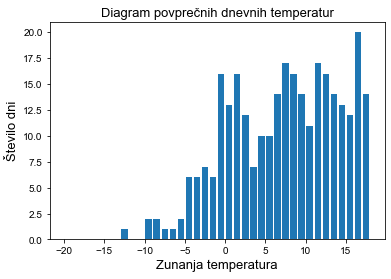

In [9]:
def displayTemperatureByTime():
    # Get the data
    data = zModel.temperaturesByTime(razredi,CSVfile)
    x = list(map(lambda x: x[0], data))
    y = list(map(lambda x: x[1], data))
    # Create bars
    plt.bar(x, y)
    # Add axis titles
    plt.xlabel('Zunanja temperatura', fontsize='13', horizontalalignment='center')
    plt.ylabel('Število dni', fontsize='13', horizontalalignment='center')
    plt.title('Diagram povprečnih dnevnih temperatur', fontsize='13')
    # Add design
    plt.style.use('seaborn-white')
    # Show graphic
    plt.show()
displayTemperatureByTime()

# Notranja projektna temperatura

Določiti moramo notranjo projektno temperaturo. Za stanovanje je $\theta_{i, ref}$: **20°C**

In [10]:
thetairef = 20 #°C

# Izračun potrebne toplotne moči toplotne črpalke

Sedaj, ko smo določili vse robne temperaturne pogoje, lahko začnemo z izračunom toplotnih moči. Če želimo določiti moč toplotne črpalke $\dot{Q}_{hp}$ moramo najprej določiti še toplotno moč potrebno za ogrevanje stavbe $\dot{Q}_{h}$, toplotno moč za pripravo STV $\dot{Q}_{stv}$ in moč drugih odjemov $\dot{Q}_{dod}$

Skupno moč tako določimo s sledečo enačbo, v kateri nastopi še korekcijski faktor akumulacije toplote:

$$\dot{Q}_{hp} =  \dot{Q}_{hp} * f_{h} + \dot{Q}_{stv} + \dot{Q}_{dod}$$

Preden določimo toplotno moč, moramo določiti vse člene zgornje enačbe.

## Korekcijski faktor
Izbran je korekcijski faktor $f_{h} = 0.93$ za opečnato stanovanjsko hišo iz 1970.



In [11]:
fh = 0.93

## Toplotna moč za ogrevanje stavbe
Toplotno moč za ogrevanje stavbe $\dot{Q}_{h}$ se izračuna kot seštevek transmisijskih, ventilacijskih in dodatnih toplotnih izgub:

$$\dot{Q}_{h} = \dot{Q}_{t} + \dot{Q}_{v}+ \dot{Q}_{h,dod}$$


### Transmisijske toplotne izgube in ventilacijske izgube
Transmisijske toplotne izgube so bile določene s pomočjo programa Gradbena fizika URSA 4, v okviru predmeta Raba Energije. V naslednji sliki so prikazani izračunani koeficijenti transmisijskih in ventilacijskih toplotnih izgub $H_{t}$ in $H_{v}$.

<img src="ursa_izracun.png">

Določimo lahko torej:

$$ H_{t} = 257.6 W/K $$
$$ H_{v} = 107.7 W/K $$
$$ H = 365.3 W/K $$

In [12]:
h = 365.3/1000 #kW/K

Za določitev moči uporabimo enačbo:

$$\dot{Q}_{h} = H*(\theta_{i,ref} - \theta_{e,ref})$$

In [13]:
dQh = h * (thetairef - thetaeref)
print(f'Toplotna moč za ogrevanje stavbe je: {round(dQh)}kW')

Toplotna moč za ogrevanje stavbe je: 12kW


## Toplotna moč za pripravo sanitarne tople vode
### Dnevna potrebna energija
Sedaj moramo določiti še toplotno moč potrebno za pripravo STV. Predpostavimo da uporabljamo zalogovnik STV. V enačbi za določitev dnevne energije STV $Q_{stv}$ upoštevamo število uporabnikov $N$, poprečno uporabo STV na osebo $q$ in temperaturno razliko med zahtevano temperaturo STV $\theta_{dp,ref}$ in temperaturo sveže dobavljene vode $\theta_{cw}$:

$$ Q_{stv} = 0.00116 *N*q*(\theta_{dp,ref}-\theta_{cw})$$

Ker se pri izračunu gre za stanovansjko poslopje je izbran $q = 60 L/ (oseba*dan)$

In [14]:
q = 25 # L/oseba*dan

Izbrati moramo še željeno temperaturo STV $\theta_{dp,ref}$, standardna je $60°C$, zato bomo to izbrali tudi mi, ter temperaturo hladne vode v omrežju $\theta_{cw}$, ki je izbrana na $12°C$

V poslopju sta dve gospodinjstvi, skupno pa trenutno v poslopju stanuje 5 oseb. Torej: $N=5$.

In [15]:
thetacw = 12 #°C
thetadpref = 60 #°C
N = 5 #število oseb

Sedaj lahko izračunamo dnevno energijo za STV.

In [16]:
Qstv = 0.00116 * N * q * (thetadpref-thetacw)
print(f'Dnevna energija potrebna za ogrevanje STV je: {round(Qstv,0)}kWh')

Dnevna energija potrebna za ogrevanje STV je: 7.0kWh


Iz energije lahko moč določimo s sledečo enačbo:
$$\dot{Q}_{stv} = \frac{Q_{stv}}{t_{stv}}*f_{stv}$$

Za $f_{stv}$ uporabimo vrednost 1.21
Čas ogrevanja STV pa izberemo da je 4 ure. $t_{stv}=4ure$

In [17]:
fstv = 1.21
tstv = 2 #ure
dQstv = Qstv/tstv*fstv
print(f'Potrebna moč za zagotavljanje nemotene oskrbe STV je {round(dQstv,0)} kW')

Potrebna moč za zagotavljanje nemotene oskrbe STV je 4.0 kW


### Velikost hranilnika STV
Najprej moramo določiti volumen vode, ki zadošča pokrivanju dnevne porabe STV, nato pa je potrebno upoštevati še dnevne toplotne izgube hranilnika STV.

Enačba ki popisuje potrebno velikost volumna vode je sledeča. V njej nastopa, poleg do sedaj že definiranih spremenljivk še dnevne toplotne izgube hranilnika $Q_{1,s}$ in učinkovitost volumna hranilnika, ki v povprečju znaša $\eta_{s} = 0.8$.

Sicer je $Q_{1,s}$ odvisen od velikosti volumna vendar, ker bomo zalogovnik izbrali iz kataloga, in ker drugi člen predstavlja veliko manjši del kot prvi, se lahko izračunu z diferencialno enačbo izognemo, ter minimalni volumen določimo le s prvim členom, drugega pa nato upoštevamo pri določitvi minimalnega volumna. 
$$V_{dp,ref}=\frac{860*(\dot{Q}_{stv}*t_{stv})}{(\theta_{dp,ref}-\theta_{cw})*\eta_{s}}+\frac{Q_{1,s}}{0.00116*(\theta_{dp,ref}-\theta_{cw})}$$

In [18]:
etas = 0.8
Vdpref1 = (860*dQstv*tstv)/((thetadpref-thetacw)*etas)
print(f'Preliminarni volumen hranilnika znaša {round(Vdpref1,0)}L')

Preliminarni volumen hranilnika znaša 189.0L


Sedaj lahko iz preliminarnega volumna določimo še toplotne izgube in jih upoštevamo v celotnem izračunu.

<img src="izgubevstv.png">

Pri preliminarnem volumnu 450L znaša dnevna izgubljena energija približno 3.2 kWh

In [19]:
Q1s = 1.5 #kWh/dan
Vdpref2 = Vdpref1 + Q1s/(0.00116 * (thetadpref-thetacw))
print(f'Volumen hranilnika znaša {round(Vdpref2,0)}L')

Volumen hranilnika znaša 216.0L


### Izbor hranilnika iz kataloga
V KRONOTERM katalogu je za izbrano ADAPT 0416 enoto na voljo 200 litrski hranilnik. Pri gospodarni rabi STV bo le-ta zadostoval. $V_{s}=200L$.

<img src="notranjaenota.png">

In [20]:
Vs = 200 #L

Na podlagi izbranega volumna lahko določimo dejansko potrebno moč toplotne črpalke po naslednji enačbi:

$$\dot{Q}_{stv,0set}=\frac{V_{s}*0.00116*(\theta_{set}-\theta_{cw})}{t_{stw}}$$

In [21]:
dQstv0set = (Vs*0.00116*(thetadpref-thetacw))/tstv
print(f'Prava moč toplotne črpalke za dobavljanje STV znaša {round(dQstv0set,0)}kW')

Prava moč toplotne črpalke za dobavljanje STV znaša 6.0kW


## Skupna toplotna moč
Sedaj lahko izračunamo še skupno toplotno moč, katero mora dosegati toplotna črpalka. To storimo s sledečo enačbo, ki je bila opisana že v začetku poglavja. Vse faktorje smo določili, tako da lahko sedaj določimo še pravo moč.

$$\dot{Q}_{hp}=\dot{Q}_{h}*f_{h}+\dot{Q}_{stv}+\dot{Q}_{dod}$$



In [22]:
dQhp = dQh * fh + dQstv0set
print(f'Skupna toplotna moč znaša {round(dQhp,0)}kW')

Skupna toplotna moč znaša 17.0kW


# Raba energije za delovanje toplotne črpalke

## Toplotna energija za ogrevanje in pripravo STV
### Toplotna energija za ogrevanje stavbe

Potrebno toplotno energijo bomo določili po naslednji enačbi.
Ker je površina južno obrnjenih oken majhna in ker je osenčenost v ogrevalni sezoni velika, se dobitke zaradi sončnega sevanja $Q_{sol,d}$ zanemari. XXX

Uporabimo enačbo:
$$Q_{h,d}=\dot{Q}_{h}*\frac{\theta_{i,ref}-\theta_{e,d}}{\theta_{i,ref}-\theta_{e,ref}}*24-Q_{hg,d}-Q_{sol,d}$$

Notranje toplotne dobitke $Q_{hg,d}$, ki predstavljajo oddajo naprav in ljudi pa določimo po povprečni vrednosti $4 W/m^{2}$

In [23]:
dQhgd = 4*181/1000
print(f'Skupni notranji toplotni dobitki znašajo {round(dQhgd,0)}kW')

Skupni notranji toplotni dobitki znašajo 1.0kW


Sedaj lahko določimo povprečne zunanje temperature na podlagi prej nastavljenih razredov. [°C]

### Toplotni dobitki sončnega sevanja

Toplotne dobitke sončenga sevanja se določi na podlagi sledeče enačbe:

$$Q_{sol,d}=\sum{A_{w,i}*(1-f_{wf,i})*g_{w,i}*G_{sol,w,i,d}}$$

Za faktor $f_{wf,i}$ privzamemo da je 0, $g_{w,i}$ je lastnost steklenih površin in je pridobljen iz URSA gradbena fizika 4, njegova vrednost je 0.67. Moč sevanja je pridobljena iz ARSO in je odvisna od ure v dnevu.

Zanimajo nas samo steklene površine na južno stran. Teh je približno 12m2.

In [24]:
Awi = 12 #m2
fwfi = 0 #/
gwi = 0.67 # /

**Opomba**

Tukaj nastopi največja šibkost metode po temperaturnih razredih. Dnevi se po razredih porazdelijo brez upoštevanja koledarskih dni in v vsakem razredu predstavljajo le število dni, ne pa tudi njihov datum. Kako torej, upoštevati radiacijske dobitke?

Ena možnost je, da namesto po povprečnih dnevnih temperatur izračun izvajamo po urah razdeljenih v razrede. Vendar ima taka razredna urna metoda svoj problem: Kako upoštevati toploto, katero zahteva ogrevanje STV? -- Ne moremo vzeti pavšalne vrednosti `ura ogrevanja stv`/`ura delovanja TČ` [h/h], saj tako nebi upoštevali možnosti, da je izredno mrzla noč, in topel dan: izračun bi prikazal veliko potrebo po dodatnem gretju s pomožnim grelcem ponoči, podnevi pa bi TČ mirovala. Seveda v realnosti temu ni tako. 

Druga možnost bi bila da gremo po dnevni metodi, vendar dnevov ne razdelimo v razrede, marveč obravnavamo vsak dan zase: Znotraj 24 ur mora biti število potrebnih ur obratovanja TČ manjše od 24, sicer nam obratuje dogrevanje. Za manjše odstopke, ko je znotraj neke ure preveč mrzlo, pa pač predpostavimo, da se v hiši temperatura (zanemarljivo) malo spusti. Taka metoda bi bila najbolj primerna, saj bi z njo lahko pravilno upoštevali sončne dobitke, potrebno toploto za ogrevanje STV in tudi toplotne izgube zaradi zunanje temperature.

Tukaj bomo te napake pri izračunu "pozabili". Nadaljujemo po dnevni metodi, ter za vsak temperaturni razred vzamemo njegovo povprečno sevanje, katerega dobimo iz ARSO CSV datoteke. Ta metoda je problematična, ker za vsak dan vzame povprečno vrednost obsevanja, ki ni pravilna, saj je ponoči sevanje 0, povprečje posledično nenatančno, določena vrednost toplotnih dobitkov pa tako manjša od dejanske,

**Konec opombe**

Metoda `temperaturesByTime` nam za vsak temperaturni razred vrne povprečno urno vrednost obsevanja: $W_{h}/m^{2}h$.

In [25]:
Gsolwid = np.array(zModel.temperaturesByTime(razredi, CSVfile, returnShape='radiation'))  #Wh/m2day

Za primer prikažemo povprečno dnevno sevanje za nek temperaturni razred. 

In [26]:
print(f'Za temperaturni razred {razredi[15]}, je povprečno dnevno sevanje {round(Gsolwid[15],2)} Wh/m2h')

Za temperaturni razred (-5, -4), je povprečno dnevno sevanje 46.85 Wh/m2h


V enem povprečnem dnevu zgornjega razreda bi torej sevanje stavbo segrelo za naslednjo količino energije:

In [27]:
print(f'Za povprečen dan temperaturnega razreda {razredi[15]}, bi sevanje v stavbo prineslo {round(Gsolwid[15]*24,2)} Wh/m2')

Za povprečen dan temperaturnega razreda (-5, -4), bi sevanje v stavbo prineslo 1124.5 Wh/m2


Vrednosti vstavimo v zgornjo enačbo, da določimo količino energije, ki je prispeva sonce.


In [28]:
Qsold = Awi*(1-fwfi)*gwi*Gsolwid*24 / (1000) 

Za nek toplotni razred bi torej v povprečnem dnevu sonce prineslo toliko energije:

In [29]:
print(f'Za povprečen dan temperaturnega razreda {razredi[15]}, bi sevanje v stavbo prineslo {round(Qsold[15],2)} kWh')

Za povprečen dan temperaturnega razreda (-5, -4), bi sevanje v stavbo prineslo 9.04 kWh


### Toplotna energija po razredih
Sedaj smo si pripravili vse podatke in vrednosti, ki jih bomo potrebovali za (relativno) natančen preračun porabe energije po temperaturnih razredih. Uporabimo enačbo. ki je podana na začetku poglavja.

$$Q_{h,d}=\dot{Q}_{h}*\frac{\theta_{i,ref}-\theta_{e,d}}{\theta_{i,ref}-\theta_{e,ref}}*24-Q_{hg,d}-Q_{sol,d}$$

Prvi člen je moč zaradi toplotnih izgub, drugi člen je moč TČ, zato moramo ta člena pomnožiti s številom ur v dnevu, ker uporabljamo dnevno metodo. Zadnji člen pa je že v dnevni energiji, zato ga ni potrebno množiti.

In [30]:
Qhd = dQh*(thetairef-thetaed)/(thetairef-thetaeref)*24-dQhgd*24 - Qsold

Ta izračun je narejen za vsak temperaturni razred (spremenljivka `thetaed`). V tem rezultatu še ni upoštevano dejansko število dni v vsakem razredu. To bomo storili v naslednjem koraku. Sedaj lahko prikažemo koliko energije bi za ogrevanje potrebovali za povprečni dan v nekem temperaturnem razredu.

Prikažemo primer nekega temperaturnega razreda.


In [31]:
print(f'Za povprečen dan temperaturnega razreda {razredi[15]}, bi za ogrevanje stavbe potrebovali {round(Qhd[15],2)} kWh')

Za povprečen dan temperaturnega razreda (-5, -4), bi za ogrevanje stavbe potrebovali 188.38 kWh


Če sedaj te izgube pomnožimo s številom dni določimo potrebno toplotno energijo za vsak razred posebej. Prikažemo primer nekega temperaturnega razreda.

In [32]:
print(f'Za vse dni v temperaturnem razredu {razredi[15]}, bi za ogrevanje stavbe potrebovali {round((Qhd*thetaedtime)[15],2)} kWh')

Za vse dni v temperaturnem razredu (-5, -4), bi za ogrevanje stavbe potrebovali 1130.28 kWh


#### Celoletna toplotna energija
Nazadnje še seštejemo toplotne energije, da dobimo celoletno toplotno energijo za ogrevanje stavbe. [kWh]

In [33]:
print(f'Za vse dni v vseh temperaturnih razredih, bi za ogrevanje stavbe potrebovali {round(np.sum(Qhd*thetaedtime),2)} kWh')

Za vse dni v vseh temperaturnih razredih, bi za ogrevanje stavbe potrebovali 21225.21 kWh


Dejanska poraba energenta v stavbi je med **2000** in **2500** litrov ekstra lahkega kurilnega olja. Izračun pokaže porabo **~21.5 MWh** energije, kar približno sovpada z realnimi podatki. Z izračunom smo tako relativno zadovoljni in lahko nadaljujemo z analizo.

### Toplotna energija za pripravo STV
Potrebno toplotno energijo za pripravo STV se določi na osnovi že določene toplotne moči, z naslednjo enačbo:
$$Q_{stv,d}=\dot{Q}_{stv,0set}*t_{stv}$$

In [34]:
Qstvd=dQstv0set*tstv
print(f'Skupna dnevna raba energije za pripravo STV znaša {round(Qstvd,2)}kWh') #

Skupna dnevna raba energije za pripravo STV znaša 11.14kWh


## Temperatura izstopajoče ogrevane vode

XXX Manjka

## Čas delovanja toplotne črpalke


Toplotna moč črpalke. Toplotno moč lahko določimo s pomočjo sledečega diagrama, katerega nam poda proizvajalec.

<img src="grelnamoč.png">

Vidimo lahko, da je padec grelne moči sorazmerno linearen. Izberemo visokotemperaturni režim 55°C. Lahko torej določimo tri točke, ter med njima potegnemo dve premici:
$T_{1}=(-25,7)$, $T_{2}=(-5,12)$, $T_{3}=(45,12)$, 

Določimo funkcijo moči:

In [35]:
from scipy import interpolate
x=np.array([-25,-5,45])
y=np.array([7,12,12])
fdQhp0 = interpolate.interp1d(x, y, kind='linear')

### Bivalentna točka
Želimo izrisati graf obratovanja toplotne črpalke. Primer grafa iz predloge.
Ločimo dva načina obratovanja toplotne črpalke: monovalentno in bivalentno obratovanje. Pri monovalentnem obratovanju toplotna črpalka pokriva celotne potrebe po toplotni moči - slika levo.

Pri bivalentnem obratovanju pa toplotna črpalka pokriva del toplotne moči, preostali del pa pokriva drugi toplotni vir - slika desno. V primeru bivalentnega obratovanje toplotne črpalke, je pri izbiri toplotne moči toplotne črpalke pomembno določitev bivalentne točke. Ta predstavlja zunanjo temperaturo do katere TČ pokriva potrebe po toploti v stavbi .

<img src="bivalentnatocka.png">


Določimo tudi funkcijo potrebne moči za ogrevanje stavbe

In [36]:
fdQh = interpolate.interp1d(thetaed, dQh*(thetairef-thetaed)/(thetairef-thetaeref), kind='linear')

Izrišemo graf naše funkcije moči in potrebne moči za ogrevanje hiše. Na presečišču se nahaja bivalentna točka. 


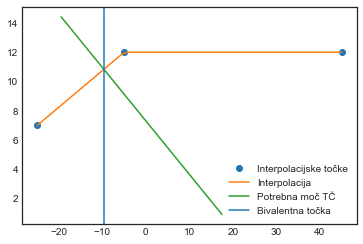

In [37]:
x_g = np.linspace(x[0], x[-1], 20*len(x)-1)
plt.plot(x, y, 'o', label='Interpolacijske točke')
plt.plot(x_g, fdQhp0(x_g), '-', label='Interpolacija')
plt.plot(thetaed,fdQh(thetaed),label='Potrebna moč TČ')
plt.axvline(x=-9.55,label='Bivalentna točka')
plt.legend();

Kot lahko opazimo je bivalentna točka nekje pri $-9.5°C$. Temperature, ki so nižje od tega zahtevajo alternativni način ogravanja, kot je opisano v začetku poglavja.

## Čas delovanja toplotne črpalke
### Teoretični čas obratovanja

Preverimo lahko še koliko ur bi morala TČ obratovati, da zadosti dnevne potrebe po toploti. Vse vrednosti nad 24 ur pomenijo, da potrebujemo alternativni vir.

Uporabimo enačbo:
$$t_{ON,hp,d}=\frac{Q_{h,d}}{\dot{Q}_{hp,h,d}}+\frac{Q_{stv,d}}{\dot{Q}_{hp,stv,d}}[h]$$

Ker ogrevanje in STV grejemo z enako črpalko uporabimo pri obeh enako moč.

In [38]:
tonhpd = Qhd / fdQhp0(thetaed) + Qstvd / fdQhp0(thetaed)

Prikažemo število obratovalnih ur za nek izbrani temperaturni razred.


In [39]:
print(f'Za povprečen dan temperaturnega razreda {razredi[15]}, bi za ogrevanje stavbe morala toplotna črpalka delovati {round(tonhpd[15],2)} ur')

Za povprečen dan temperaturnega razreda (-5, -4), bi za ogrevanje stavbe morala toplotna črpalka delovati 16.63 ur


### Čas obratovanja dogrevanja
Ker naša toplotna črpalka ne zadostuje zahtevani moči v vseh temperaturnih razredih, moramo moč dodajati z dodatnim grelcem. Ta je izveden kot navadni električni grelec ki vso svojo moč pretvori v toploto. Predvideti želimo koliko časa bo moral grelec delovati.
To storimo s sledečo enačbo:
$$t_{ON,pu,d}=\frac{Q_{h,d}+Q_{stv,d}+Q_{dod,d}-(Q_{h,hp,d}+Q_{stv,hp,d}+Q_{dod,hp,d})}{\dot{Q}_{pu}}$$

Ker ogrevanje in STV grejemo iz istega vira (TČ) bomo upoštevali celotno energijo, ki jo TČ lahko dobavi v enem dnevu. Prav tako ni dodatnih ponorov toplote, zato teh členov ne upoštevamo. Dobimo sledečo enačbo:
$$t_{ON,pu,d}=\frac{Q_{h,d}+Q_{stv,d}-Q_{hp,d}}{\dot{Q}_{pu}} [h]$$

Za vsak temperaturni razred preverimo koliko časa mora delovati pomožni grelec. Negativne vrednosti pomenijo da toplotna črpalka zagotavlja presežek energije. Enote so v urah.

V poglavju **Izbor hranilnika iz kataloga** lahko vidimo, da ima izbrana *TČ ADAPT 0416 K3 HT / HK 1F*  $2*2kW$ grelec.

<img src="notranjaenota.png">

In [40]:
dQpu = 4 #kW

Uporabimo zgornjo enačbo, da določimo število ur obratovanja dogrevanja za vsak temperaturni razred. Člen za energijo TČ pomnožimo s 24, saj nam funkcija `fdQhp0` poda moč za vsak temperaturni razred, ne pa energije.

Negativna vrednost pomeni, da dogrevanje ni potrebno in da TČ ustvarja presežek energije.
Prikažemo primer nekega temperaturnega razreda.

In [41]:
tonpud = (Qhd + Qstvd - fdQhp0(thetaed)*24) / dQpu 
print(f'Za povprečen dan temperaturnega razreda {razredi[15]}, bi za ogrevanje stavbe moralo dogrevanje delovati {round(tonpud[15],2)} ur')

Za povprečen dan temperaturnega razreda (-5, -4), bi za ogrevanje stavbe moralo dogrevanje delovati -22.12 ur


Sedaj moramo določiti še dejansko število ur obratovanja, ki je odvisno od števila dni v vsakem temperaturnem razredu. Negativne vrednosti, podobno kot prej pomenijo presežek energije TČ, in torej, ne-delovanje grelca.
Prikažemo primer nekega temperaturnega razreda.

In [42]:
ar = tonpud * thetaedtime
print(f'Za temperaturni razred {razredi[15]}, za ogrevanje stavbe mora dogrevanje delovati {round(ar[15],2)} ur')

Za temperaturni razred (-5, -4), za ogrevanje stavbe mora dogrevanje delovati -132.73 ur


Zanima nas še skupno število obratovalnih ur dogrevanja. Za vsak temperaturni razred moramo torej pomnožiti z številom dni v razredu. Negativne vrednosti pomenijo da toplotna črpalka zagotavlja presežek energije in da ne potrebujemo dogrevanja.

In [43]:
tonpu = ar[ar>0].sum()
print(f'Skupno število ur obratovanja dogrevanja {round(tonpu,0)} ur')

Skupno število ur obratovanja dogrevanja 6.0 ur


## Raba električne energije za delovanje toplotne črpalke
Rabo električne energije za delovanje toplotne črpalke določimo na osnovi obratovalnih karakteristik toplotne črpalke in njenega časa obratovanja.

Določili bomo porabo na osnovi rabe toplotne energije in učinkovitosti toplotne črpalke, s sledečo enačbo:

$$E_{hp,d}=\frac{Q_{h,d}}{COP_{h,s}}+\frac{Q_{stv,d}}{COP_{stv,s}}$$

Originalna enačba kliče po uporabi dnevne COP vrednosti, vendar le-te proizvajalec v katalogu ne podaja. Prav tako proizvajalec ne podaja COP v odvisnosti od zunanje temperature, zato bomo uporabili sezonski COP, ki je za toplotni režim 55°C: $COP_{s}=3.75$

<img src="cop.png">

In [44]:
COPs=3.75

Za naše pogoje v vseh toplotnih režimih je poraba električne energije izračunana sledeče. Prikažemo primer nekega temperaturnega razreda.

In [45]:
Ehpd = Qhd * thetaedtime / COPs 
print(f'Poraba električne energije za vse dni temperaturnega razreda {razredi[15]} je {round(Ehpd[15],0)} kWh')

Poraba električne energije za vse dni temperaturnega razreda (-5, -4) je 301.0 kWh


Če želimo določiti skupno celoletno porabo, moramo ogrevanju prišteti še porabo elektrike za pripravo STV. Skupna sezonska poraba TČ je torej:
    

In [46]:
Ehp = (Ehpd).sum() + Qstvd * 365 / COPs   #kWh
print(f'Poraba električne energije za ogrevanje stanovanja in pripravo STV za vse dni v letu  je {round(Ehp,2)} kWh')

Poraba električne energije za ogrevanje stanovanja in pripravo STV za vse dni v letu  je 6743.96 kWh


# Sezonski faktor učinkovitosti
Sezonski faktor učinkovitosti oz. SPF ovrednotimo z razmerjem med proizvedeno toploto in vloženo energijo. Za primer električno gnane toplotne črpalke z dodatnim električnih grelcem se sezonski faktor učinkovitosti sistema SPF določi po sledeči enačbi:

$$SPF=\frac{Q_{h}+Q_{stv}+Q_{dod}}{E_{hp}+E_{bu}+E_{aux}}$$

V katalogu lahko razberemo, da je moč obtočne črtpalke $75W$. Dolžina ogrevalne sezone je **140 dni**

In [47]:
Paux = 75/1000 #kW

In [48]:
SPF = ((Qhd*thetaedtime).sum() + Qstvd*365 ) / ( Ehp + Paux*140 + tonpu*4)
print(f'Sezonski faktor učinkovitosti je {round(SPF,1)}')

Sezonski faktor učinkovitosti je 3.7


# Ekonomska analiza toplotnih črpalk
Poleg učinkovitosti in vpliva na okolje je za končne uporabnike praviloma najbolj pomembna ekonomska analiza. Pri njej je potrebno upoštevati ceno sistema, način investice in stroške kreditiranja ter obratovanja.

## Vračilna doba
Prva in najbolj pomembna metrika pri ekonomski analizi je vračilna doba.  Z naslednjo enačbo lahko izračunamo letni obrok kreditiranja.

$$\alpha=\frac{c_{inv,hp}*r_{int}^{y}*(r_{int}-1)}{(r_{int}^{y}-1)}$$

Potrebujemo izbrati število let financiranja, obrestno mero in strošek začetne investicije.
$r_{int}$ se določi s pomočjo obrestne mere, in sicer s sledečo enačbo:

$$r_{int}=1+\frac{p_{int}}{100}$$

Kjer je $p_{int}$ obrestna mera.

In [53]:
pint = 1.5 #%
year = 10 #let
cinvhp = 10000 #€
rint = 1 + pint / 100

In [59]:
alfa = (cinvhp*rint**year*(rint-1))/(rint**year-1)
print(f'Letni strošek financiranja je {round(alfa,1)}€')
print(f'Skupni strošek financiranja je {round(alfa*year,1)}€')

Letni strošek financiranja je 1084.3€
Skupni strošek financiranja je 10843.4€


## Stroški obratovanja
